In [1]:
import os, string, shapely, itertools

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import shapely.ops as so

from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from shapely.ops import cascaded_union
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_input     = '/Users/Guille/Desktop/india_power/input_data/'
path_to_load      = '/Users/Guille/Desktop/india_power/input_data/load'

# Demand Profiles

In [2]:
def _load_system_demand_scenarios(scens_, scen_labels_, path):

    dfs_ = []
    for scen, scen_label in zip(scens_, scen_labels_):
        df_             = pd.read_csv(path + '/' + scen + '/Demandhourly2020-2050-India.csv')
        df_['scenario'] = scen_label
        dfs_           += [df_]
          
    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _plot_monthly_demand_comparison(ax_, df_, scen_labels_, fys_, i_month, 
                                    ylabel = 'Demand (GWh)',
                                    xlabel = 'Time (hh:mm)'):
    
    months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ls_ = ['dotted', 'dashed', 'dashdot', 'solid']

    x_ = np.linspace(0, 23, 24)

    colors_ = ['#136564', '#2cb7b5', '#756a01', '#ca8250', '#d8a581']
    ls_    = ['dashed', 'solid']

    for fy, j in zip(fys_, range(len(fys_))):
        for scen_label, k in zip(scen_labels_, range(len(scen_labels_))):

            idx_  = (df_['FY'] == fy) & (df_['Month'] == i_month + 1) & (df_['scenario'] == scen_label)
            df_p_ = df_.loc[idx_, ['Day', 'Interval', 'India']].reset_index(drop = True)

            df_pp_ = np.concatenate([df_p_.loc[df_p_['Day'] == d, 'India'].reset_index(drop = True).to_numpy()[:, np.newaxis] 
                                     for d in np.sort(df_p_['Day'].unique())], axis = 1)

            if method == 'avg': y_ = np.mean(df_pp_, axis = 1)
            if method == 'max': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmax()]
            if method == 'min': y_ = df_pp_[:, np.min(df_pp_, axis = 0).argmin()]

            if (fy == 2020) & (scen_label == r'Linearly-scaled Demand'):
                ax_.plot(x_, y_/1e3, 
                         c     = '#92918b', 
                         label = '2020 Historical Demand',
                         ls    = 'solid',
                         lw    = 2.5,
                         alpha = 0.75)
                continue
                
            if (fy == 2020) & (scen_label == r'Bottom-up Modified Demand'):
                continue
                
            ax_.plot(x_, y_/1e3, 
                     c     = colors_[k], 
                     label = '2050 ' + scen_label,
                     ls    = 'solid',
                     lw    = 2.5,
                     alpha = 0.75)
    
    ax_.set_ylabel(ylabel, fontsize = 22)
    #ax_.set_xlabel(xlabel, fontsize = 20)

    #ax_.set_xticks(x_[::4], ["%02d:00" % x for x in x_][::4], rotation = 90)
    ax_.set_xticks([0, 12, 23], ['1am', '12pm', '12am'], rotation = 22.5)

    ax_.xaxis.set_tick_params(labelsize = 20)
    ax_.yaxis.set_tick_params(labelsize = 20, left = False)

    ax_.set_xlim(0, 23)
    ax_.set_ylim(-5, 1075)

    ax_.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax_.set_title(months_[i_month], fontsize = 24, y = 1.)

    ax_.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax_.grid(axis = 'y', lw = 1.25, ls = ':')
    
    ax_.axhline(0, linewidth = 1.25, 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 10)

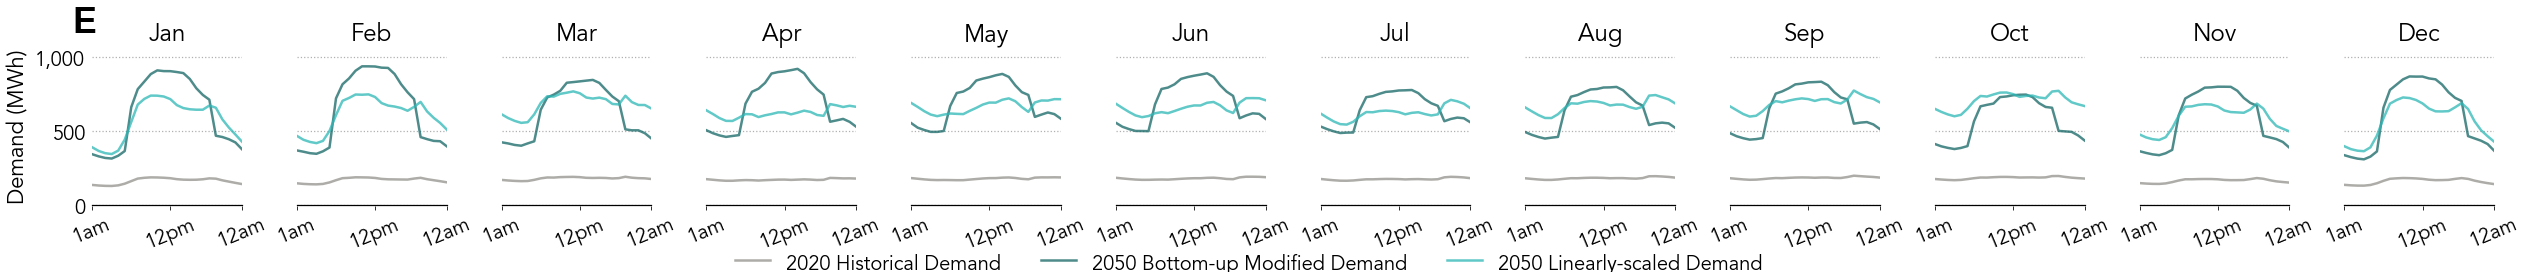

In [3]:
method = 'avg'

scen_labels_ = [r'Bottom-up Modified Demand', 
                r'Linearly-scaled Demand']

scens_ = ['2050-demand_forecast-transmission-PIERv2_2019_mid',
          '2050-demand_forecast-transmission-ICED_2019_mid']

fys_   = [2020, 2050]

df_ = _load_system_demand_scenarios(scens_, scen_labels_, path_to_load)

fig, _ax = plt.subplot_mosaic([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']],
                              layout      = 'constrained', 
                              figsize     = (35, 3.5), 
                              sharey      = True,
                              gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

_ax['A'].text(0.0, 1.0, 'E', 
        transform = _ax['A'].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
        fontsize  = 36, 
        weight    = "bold",
        va        = 'bottom',
        family    = 'Arial')
    
_plot_monthly_demand_comparison(_ax['A'], df_, scen_labels_, fys_, 0, ylabel = 'Demand (MWh)', xlabel = '')
_plot_monthly_demand_comparison(_ax['B'], df_, scen_labels_, fys_, 1, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['C'], df_, scen_labels_, fys_, 2, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['D'], df_, scen_labels_, fys_, 3, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['E'], df_, scen_labels_, fys_, 4, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['F'], df_, scen_labels_, fys_, 5, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['G'], df_, scen_labels_, fys_, 6, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['H'], df_, scen_labels_, fys_, 7, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['I'], df_, scen_labels_, fys_, 8, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['J'], df_, scen_labels_, fys_, 9, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['K'], df_, scen_labels_, fys_, 10, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['L'], df_, scen_labels_, fys_, 11, ylabel = '', xlabel = '')

handles, labels = _ax['L'].get_legend_handles_labels()
fig.legend(handles, labels, loc          = (0.2875, -0.0375),
                            frameon      = False,
                            handlelength = 1.75,
                            ncol         = 3,
                            prop         = {'size': 20})

plt.savefig(path_to_images + f'/overview-demand_profiles.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + f'/overview-demand_profiles.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Electricity Generation 2020

In [4]:
def _load_system_demand_scenarios(scenario, path):

    dfs_ = []
    for file in os.listdir(path + "/" + scenario):
        if file.endswith(".csv"):
            #print(file)
            dfs_ += [pd.read_csv(path + '/' + scenario + '/' + file)]

    df_ = dfs_[0]
    for i in range(len(dfs_) - 1):
        df_ = df_.merge(dfs_[i + 1], on = ['FY', 'Month', 'Day', 'Interval', 'Year'])

    df_ = df_.drop(columns = ['Bhutan', 'India'])
    return df_


tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv')

df_   = _load_system_demand_scenarios(scenario = '2050-demand_forecast-transmission-ICED_2019_mid', path = path_to_load)
df_p_ = df_.loc[df_['FY'] == 2020].copy()
df_p_ = df_p_[df_p_.columns[5:]].T

In [5]:
gen_ = pd.read_csv(path_to_input + "india_gen_2019-20.csv")
idx_ = gen_['state'] == 'Andaman and Nicobar Islands'
gen_ = gen_.loc[~idx_].reset_index(drop = True)

gen_.loc[gen_['source'] == 'Oil & Gas', 'source']   = 'Gas'
gen_.loc[gen_['source'] == 'Bio Power', 'source']   = 'Other'
gen_.loc[gen_['source'] == 'Small Hydro', 'source'] = 'Hydro'

gen_['type'] = 'clean'

gen_.loc[gen_['source'].isin(['Coal', 'Gas', 'Diesel', 'Nuclear']), 'type'] = 'no_clean'

gen_ = gen_[['state', 'source', 'type', 'generation_gwh']]
gen_ = gen_.groupby(['state', 'source', 'type', 'generation_gwh']).agg('sum').reset_index(drop = False)

gen_['state'] = gen_['state'].apply(lambda x: x.replace(' ', '_'))
gen_['state'] = gen_['state'].apply(lambda x: x.replace('_and_', '_'))

gen_ = gen_.rename(columns = {'state': 'load_zone', 'source': 'technology'})

In [6]:
city_ = pd.read_csv(path_to_input + r"transmission/major_cities_india.csv")
city_ = city_.drop(columns = ['state', 'major_city'])
city_ = city_.rename(columns = {'acronym': 'load_zone_abr'})

In [7]:
load_zones_ = pd.read_csv(path_to_input + r"/load_zones.csv")
load_zones_ = load_zones_.drop(columns = ['state', 'rps_zone'])
#load_zones_ = load_zones_.drop([35, 36]).reset_index(drop = True)
print(load_zones_)
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')
print(load_zones_)

demand_ = pd.DataFrame(np.vstack([np.sum(df_p_.to_numpy(), axis = 1), 
                                  df_p_.index.values]).T, columns = ['load_mw', 'load_zone'])
#demand_ = demand_.drop([1, 26]).reset_index(drop = True)
demand_.loc[len(demand_)] = [0, 'Bhutan']
demand_ = pd.merge(demand_, load_zones_, on  = 'load_zone', 
                                         how = 'inner')
print(demand_)

             load_zone load_zone_abr
0       Andhra_Pradesh            AP
1    Arunachal_Pradesh            AR
2                Assam            AS
3               Bhutan            BH
4                Bihar            BR
5           Chandigarh            CH
6         Chhattisgarh            CG
7   Dadra_Nagar_Haveli            DH
8            Daman_Diu            DD
9                Delhi            DL
10                 Goa            GA
11             Gujarat            GJ
12             Haryana            HR
13    Himachal_Pradesh            HP
14       Jammu_Kashmir            JK
15           Jharkhand            JH
16           Karnataka            KA
17              Kerala            KL
18      Madhya_Pradesh            MP
19         Maharashtra            MH
20             Manipur            MN
21           Meghalaya            ML
22             Mizoram            MZ
23            Nagaland            NL
24              Odisha            OR
25          Puducherry            PY
2

In [8]:
cost_                = {}
cost_['scen_labels'] = pd.read_csv(path_to_csvs + '/retirements-scenario_labels.csv')

path_to_scen = cost_['scen_labels']['path'].to_numpy()[0]
scen         = cost_['scen_labels']['scenario'].to_numpy()[0]

In [9]:
project_timepoint_ = pd.read_csv(f'{path_to_scen}/{scen}/results/project_timepoint.csv', low_memory = False)
project_period_    = pd.read_csv(f'{path_to_scen}/{scen}/results/project_period.csv', low_memory = False)

project_timepoint_['gen_mw'] = project_timepoint_['number_of_hours_in_timepoint'] * project_timepoint_['timepoint_weight'] * project_timepoint_['power_mw']
project_timepoint_           = project_timepoint_[['period', 'load_zone', 'technology', 'gen_mw']]
project_period_              = project_period_[['period', 'load_zone', 'technology', 'capacity_mw']]

project_timepoint_ = project_timepoint_.groupby(['period', 
                                                 'load_zone', 
                                                 'technology']).agg('sum').reset_index(drop = False)

project_period_    = project_period_.groupby(['period', 
                                              'load_zone', 
                                              'technology']).agg('sum').reset_index(drop = False)

project_timepoint_ = project_timepoint_.loc[project_timepoint_['period'] == 2020].reset_index(drop = True)
project_period_    = project_period_.loc[project_period_['period'] == 2020].reset_index(drop = True)

project_ = pd.merge(project_period_, project_timepoint_, on  = ['period', 'technology', 'load_zone'], 
                                                         how = 'inner').drop(columns = ['period'])
print(project_)

          load_zone              technology  capacity_mw        gen_mw
0    Andhra_Pradesh                 Battery        0.000  0.000000e+00
1    Andhra_Pradesh                 Biomass      483.670  2.125407e+05
2    Andhra_Pradesh                    CCGT     4898.544  2.808977e+06
3    Andhra_Pradesh                      CT        0.000  0.000000e+00
4    Andhra_Pradesh               Hydro_ROR       50.000  5.337519e+04
..              ...                     ...          ...           ...
310     West_Bengal            SolarPV_tilt      110.000  1.682486e+05
311     West_Bengal  Subcritical_Coal_Large     4500.000  3.108237e+07
312     West_Bengal  Subcritical_Coal_Small     9196.948  6.105480e+07
313     West_Bengal      Supercritical_Coal     1200.000  8.508995e+06
314     West_Bengal                    Wind        0.000  0.000000e+00

[315 rows x 4 columns]


In [10]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['technology', 
                                   'load_zone']).agg({'capacity_mw': 'sum', 
                                                      'gen_mw': 'sum'})

    return capacity_.reset_index(drop = False)


tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 
captive_     = pd.read_csv(path_to_input + r"/generators/existing_captive_generators_2022.csv")

grouped_project_ = _group_capacity_technologies(project_, tech_labels_)
grouped_project_ = grouped_project_.loc[grouped_project_['technology'] == 'Coal'].reset_index(drop = True)
grouped_project_['cf'] = grouped_project_['gen_mw']/(grouped_project_['capacity_mw']*8760)
grouped_project_ = grouped_project_[['technology', 'load_zone', 'cf']]
# print(grouped_project_)
captive_ = captive_[['load_zone', 'gen_capacity']].drop([5]).reset_index(drop = True)

captive_ = pd.merge(grouped_project_, captive_, on  = ['load_zone'], 
                                                how = 'inner')
print(captive_)


captive_['generation_gwh'] = .77 * captive_['gen_capacity'] * captive_['cf'] * 8760 / 1000
captive_['type'] = 'no_clean'

captive_ = captive_[['load_zone', 'technology', 'type', 'generation_gwh']]
total_gen_ = pd.concat([gen_, captive_], axis = 0).reset_index(drop = True)
total_gen_ = total_gen_.groupby(['technology', 
                                 'load_zone', 
                                 'type']).agg('sum').reset_index(drop = False)
print(total_gen_)
print(total_gen_['load_zone'].unique())
print(total_gen_['load_zone'].unique().shape)

   technology         load_zone        cf  gen_capacity
0        Coal    Andhra_Pradesh  0.416818      1928.618
1        Coal             Assam  0.000000       133.310
2        Coal             Bihar  0.512728       225.500
3        Coal        Chandigarh  0.470301        14.400
4        Coal      Chhattisgarh  0.727665      7791.048
5        Coal               Goa  0.448346        84.320
6        Coal           Gujarat  0.618594      4124.705
7        Coal           Haryana  0.208626       374.300
8        Coal  Himachal_Pradesh  0.475178        33.100
9        Coal         Jharkhand  0.722475      1405.120
10       Coal         Karnataka  0.137625      3970.921
11       Coal            Kerala  0.144060        62.300
12       Coal    Madhya_Pradesh  0.694324      2687.703
13       Coal       Maharashtra  0.290966      3867.499
14       Coal         Meghalaya  0.427778        38.800
15       Coal            Odisha  0.672055     10782.680
16       Coal        Puducherry  0.457708       

In [11]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity_retirements(scen_labels_):

    # Load project capacity table and process them from database
    def __load_pipeline_and_existing_csv(df_, scenario):

        df_ = df_[['project', 
                   'period', 
                   'technology', 
                   'load_zone', 
                   'capacity_mw', 
                   'energy_capacity_mwh']]

        df_  = df_.loc[~df_['project'].isin(['_new'])].reset_index(drop = True)
        
        df_['status'] = 'existing'
        
        df_.loc[df_['project'].str.contains('_pipeline'), 'status'] = 'pipeline'
        df_.loc[df_['project'].str.contains('_new'), 'status'] = 'new'
        df_.loc[df_['project'].str.contains('2029'), 'status'] = 'pipeline'

        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone',
                           'status']).agg({'capacity_mw': 'sum', 
                                           'energy_capacity_mwh': 'sum'})

        df_ = df_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_['scenario'] = scenario

        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_pipeline_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)


def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status', 
                                   'scenario']).agg({'capacity_mw': 'sum', 
                                                     'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)



def _group_by_zone(df_, scen_labels_, columns_ = ['period', 
                                                  'technology', 
                                                  'scenario', 
                                                  'load_zone', 
                                                  'status']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                 = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']       = df_['period'].astype(int)
    df_['capacity_mw']  = df_['capacity_mw'].astype(float)
    df_['capacity_mwh'] = df_['capacity_mwh'].astype(float)

    return df_

retirements_         = _load_capacity_retirements(cost_['scen_labels'])
grouped_retirements_ = _group_capacity_technologies(retirements_, tech_labels_)
grouped_retirements_ = _group_by_zone(grouped_retirements_, cost_['scen_labels'])

VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


In [12]:
def _plot_retirements_and_pipeline_capacity(ax, df_, scens_label_, tech_label_, 
                                            units        = 1e3,
                                            ylabel       = 'Retirements & Pipeline (GW)',
                                            y_lim_max = 500.,
                                            y_grid_inc   = 100,
                                            legend       = True,
                                            title        = ''):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        # for tech, i_tech in zip(techs_, range(len(techs_))):
        #     idx_ = df_['technology'] == tech
        #     if idx_.sum() > 0:
        #         if df_.loc[idx_, 'capacity_mw'].sum() != 0:
        #             ax.bar(0., 0., 0., bottom = 0.,
        #                                color  = colors_[i_tech],
        #                                label  = tech,
        #                                zorder = 10)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 0.5
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):
        print(scen, zone)
        df_p_ = df_.copy()

        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'pipeline')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)

    ax.axhline(0., linewidth = .75,
                   linestyle = '-',
                   color     = 'k',
                   clip_on   = False,
                   zorder    = 10)

    ax.set_ylabel(ylabel, fontsize = 22)

    if legend:
        ax.legend(loc            = 'upper left',
                  frameon        = False,
                  prop           = {'size': 20})

    if y_lim_max != None:
        ax.set_ylim(0., y_lim_max)
        y_max = y_lim_max
    else:
        ax.set_ylim(0., y_period_.max()*1.2)
    y_max /= units
        
#     N_steps  = int(np.ceil(y_max/y_grid_inc))
#     y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)
    
#     ax.set_yticks(y_ticks_, y_ticks_)
    ax.set_xticks(x_period_, periods_)

    ax.xaxis.set_tick_params(labelsize = 20, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 20, 
                             left      = False)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.axhline(0, linewidth = 1.25, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    #ax.set_title(title, fontsize = 20, y = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y', lw = 1.25, ls = ':')    

def _plot_dispatch_by_zone(ax, df_1_, df_2_, tech_label_,
                           units       = 1e3,
                           y_lim_min   = -10,
                           y_lim_max   = 10,
                           ylabel      = r'Electricity Generation (TWh)',
                           title       = ''):

    def __make_dispatch_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'generation_gwh'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    total_ = df_1_.groupby(['load_zone']).agg('sum').reset_index(drop = False)#.sort_values('generation_gwh', ascending = False)
    #total_ = df_1_.loc[df_1_['type']== 'clean'].groupby(['state']).agg('sum').reset_index(drop = False).sort_values('generation_gwh', ascending = False)
    #print(total_)
    total_ = total_.loc[total_['generation_gwh'] > 0.].reset_index(drop = True)
        
    #zones_ = total_['load_zone'].to_numpy()
    
    zones_ = df_2_.sort_values('load_mw', ascending = False)['load_zone'].to_numpy()
    abrs_  = df_2_.sort_values('load_mw', ascending = False)['load_zone_abr'].to_numpy()

    width = 0.75
    x_    = np.linspace(0, len(zones_) - 1, len(zones_))

    ticks_    = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0
    
    gen = 0.
    demand = 0.

    __make_dispatch_legend(ax, df_1_, tech_label_)
    
    for zone, i_zone in zip(zones_, range(len(zones_))):

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = (df_1_['load_zone'] == zone) & (df_1_['technology'] == tech)

            if (idx_.sum() > 0):
                power = df_1_.loc[idx_, 'generation_gwh'].sum()

                if power != 0:
                    if power > 0:
                        offset = offset_positive
                    else:
                        offset = offset_negative
                    gen += power/units
                    ax.bar(x_[i_zone], power/units, width, bottom = offset/units,
                                                           color  = color,
                                                           zorder = 2,
                                                           ec     = 'None',
                                                           lw     = 0.,
                                                           aa     = True)

                    if power >= 0:
                        offset_positive += power
                    else:
                        offset_negative += power

        if offset_negative/units < y_min: 
            y_min = offset_negative/units
        if offset_positive/units > y_max: 
            y_max = offset_positive/units

        #idx_ =#.replace(' and ', ' ').replace(' ', '_')
        power = df_2_.loc[df_2_['load_zone'] == zone, 'load_mw'].to_numpy()[0]/1e6

        if i_zone == 0:
            ax.plot(x_[i_zone], power, marker          = 'o', 
                                       c               = 'white', 
                                       label           = 'Demand (TWh)',
                                       zorder          = 6,
                                       markersize      = 10,
                                       markeredgewidth = 2.5,
                                       markeredgecolor = 'k', clip_on = False)
        else:
            ax.plot(x_[i_zone], power, marker          = 'o', 
                                       c               = 'white', 
                                       zorder          = 6, 
                                       markersize      = 10,
                                       markeredgewidth = 2.5,
                                       markeredgecolor = 'k', clip_on = False)
            
        ticks_.append(x_[i_zone])
        x_period_.append(x_[i_zone])
        y_period_.append(offset_positive)

        offset_positive = 0.
        offset_negative = 0.

    x_ = x_ + .9/len(zones_)  
    
    labels_ = []
    for zone, abr in zip(zones_, abrs_):
        #abr = abr.replace("JK", "JKLA")
        label = '{} ({})'.format(zone.replace("_", " "), abr)
        label = label.replace("Jammu Kashmir", "Jammu, Kashmir & Ladakh")
        label = label.replace("Dadra Nagar Haveli (DH)", "Dadra & Nagar Haveli (DHDD)")
        labels_.append(label)
        
        
    #labels_ = ['{} ({})'.format(zone.replace("_", " "), abr) for zone, abr in zip(zones_, abrs_)]
    ax.set_xticks(ticks_, labels_, rotation = 90, fontsize = 22)
    ax.xaxis.set_tick_params(labelsize = 20, left = False)
    ax.set_ylabel(ylabel, fontsize = 22)
    ax.yaxis.set_tick_params(labelsize = 20, left = False)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    # if legend:
    #     ax.legend(bbox_to_anchor = (1., 0.95),
    #               frameon        = False,
    #               prop           = {'size': 20})

    ax.set_ylim(y_lim_min, y_lim_max)

    ax.set_xlim(-.75, len(zones_) - 0.25)

    #ax.set_title(title, fontsize = 18)
    ax.axhline(0, linewidth = 1.25, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 5)
    
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y', lw = 1.25, ls = ':')

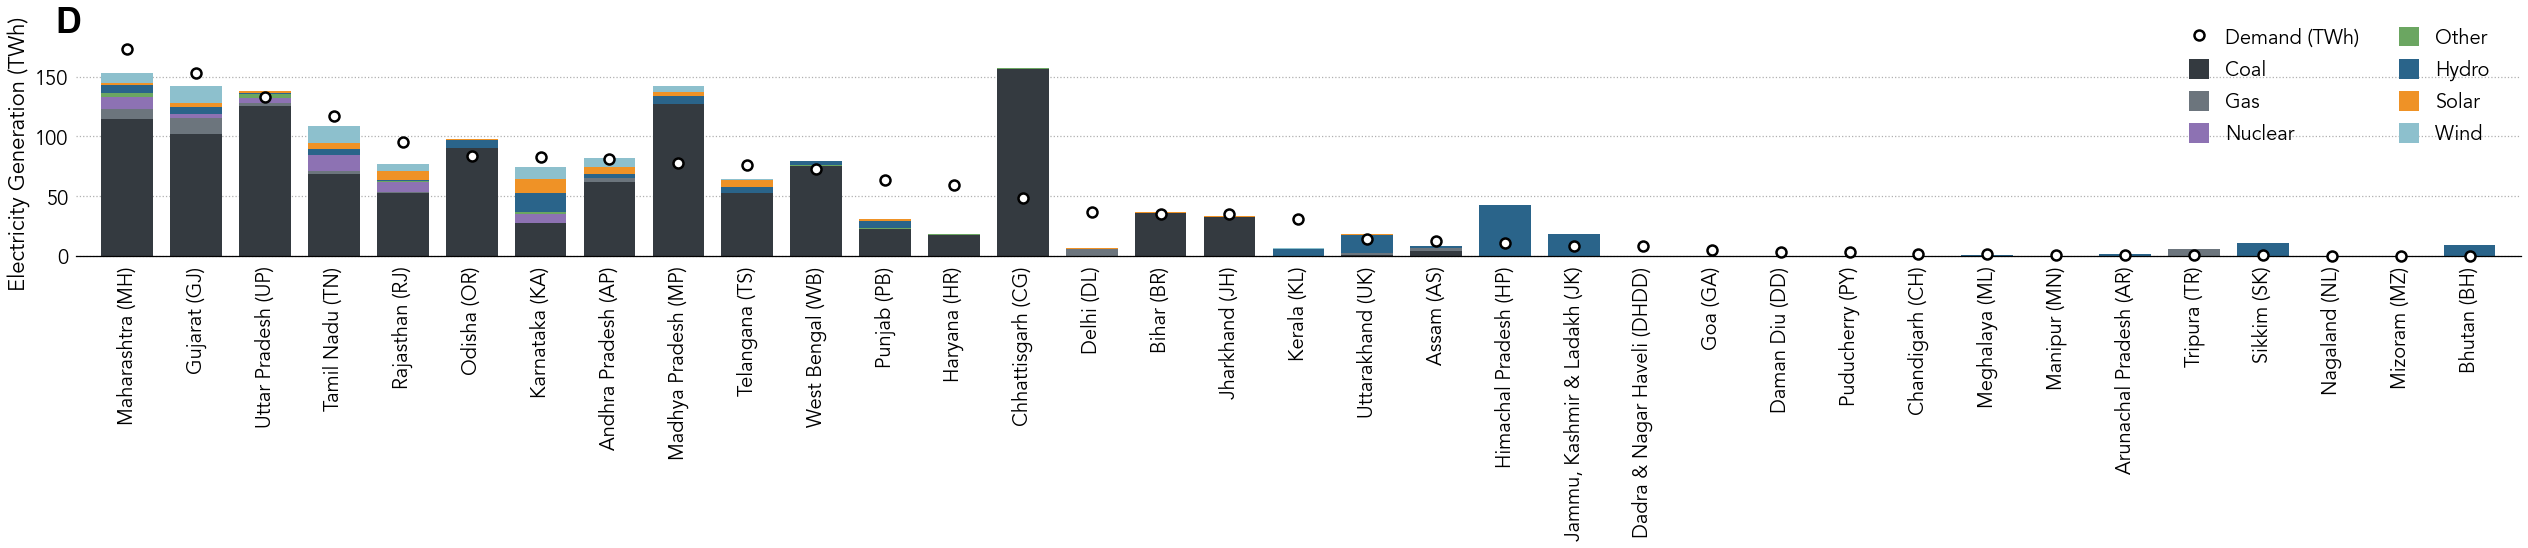

In [17]:
# fig, _ax = plt.subplot_mosaic([['D', 'E']],
#                               layout      = 'constrained', 
#                               figsize     = (35, 7.5), 
#                               gridspec_kw = {'wspace': 0.05,
#                                              'width_ratios': [3, .6]})

fig, _ax = plt.subplot_mosaic([['D']],
                              layout      = 'constrained', 
                              figsize     = (35, 7.5), 
                              gridspec_kw = {'width_ratios': [1]})

# _ax['D'].text(0.0, 1.0, 'D', 
#         transform = _ax['D'].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
#         fontsize  = 3, 
#         weight    = "bold",
#         va        = 'bottom',
#         family    = 'Arial')

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 36, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

_plot_dispatch_by_zone(_ax['D'], total_gen_, demand_, tech_labels_, 
                       y_lim_min   = -2.5,
                       y_lim_max   = 175,
                       title       = f' ',
                       ylabel      = 'Electricity Generation (TWh)')

handles, labels = _ax['D'].get_legend_handles_labels()
fig.legend(handles, labels, #loc          = 'upper center',
                                    loc          = (0.8625, 0.72),
                                    frameon      = False,
                                    ncol         = 2,
                                    prop         = {'size': 20})

# _plot_retirements_and_pipeline_capacity(_ax['E'], grouped_retirements_, cost_['scen_labels'] , tech_labels_,
#                                         y_lim_max = 499,
#                                         legend = False,
#                                         ylabel = 'Retirements & \n Pipeline Capacity (GW)') 

# handles, labels = _ax['E'].get_legend_handles_labels()
# fig.legend(handles, labels, #loc          = 'upper center',
#                             loc          = (0.94, 0.9),
#                             frameon      = False,
#                             ncol         = 2,
#                             prop         = {'size': 20})


plt.savefig(path_to_images + f'/overview-state_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + f'/overview-state_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Technology Cost Projections

In [50]:
# New projects costs and operational characteristics
new_projects_excel            = path_to_input + "new_projects_v41.xlsx"
new_battery_costs_all         = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_battery_costs_2050")
new_hydrogen_cavern_costs_all = pd.read_excel(new_projects_excel, sheet_name = "new_hydrogen_cavern_costs_2050")
new_hydrogen_tank_costs_all   = pd.read_excel(new_projects_excel, sheet_name = "new_hydrogen_tank_costs_2050")
new_solar_costs_all           = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_solar_costs_2050")
new_wind_costs_all            = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_wind_costs_2050")
new_conventional_costs_all    = pd.read_excel(new_projects_excel, sheet_name = "new_conventional_costs_2050")
new_nuclear_costs_all         = pd.read_excel(new_projects_excel, sheet_name = "new_nuclear_costs_2050")
new_hydro_costs_all           = pd.read_excel(new_projects_excel, sheet_name = "new_hydro_pumped_costs_2050")

# Exchange Rate
USD_to_INR = 72

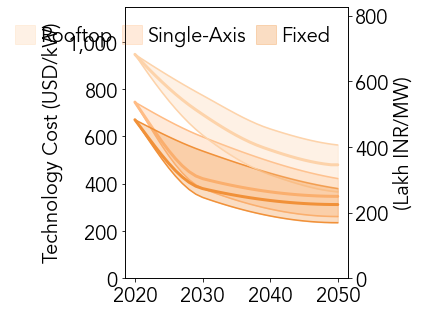

In [51]:
def _plot_solar_cost(ax, df_, 
                     ylabel  = r'Technology Cost (USD/kW)',
                     yplabel = r'(Lakh INR/MW)',
                     xlabel  = True):

    idx_single_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_single')
    idx_single_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_single')
    idx_single_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_single')

    idx_tilt_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_tilt')
    idx_tilt_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_tilt')
    idx_tilt_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_tilt')

    idx_roof_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_roof')
    idx_roof_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_roof')
    idx_roof_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_roof')
    
    ax.plot(df_.loc[idx_roof_low_, 'vintage'], df_.loc[idx_roof_low_, 'capital_real_cost_per_kw'],
            color = '#fdd3aa', lw = 1.5, zorder = 2, solid_capstyle='round')
    ax.plot(df_.loc[idx_roof_mid_, 'vintage'], df_.loc[idx_roof_mid_, 'capital_real_cost_per_kw'],
            color = '#fdd3aa', lw = 3, zorder = 2, solid_capstyle='round')
    ax.plot(df_.loc[idx_roof_high_, 'vintage'], df_.loc[idx_roof_high_, 'capital_real_cost_per_kw'],
            color = '#fdd3aa', lw = 1.5, zorder = 2, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_roof_mid_, 'vintage'], 
                    df_.loc[idx_roof_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_roof_high_, 'capital_real_cost_per_kw'], 
                    color = '#fdd3aa', alpha = .3, label = 'Rooftop', zorder = 2)
    
    ax.plot(df_.loc[idx_single_low_, 'vintage'], df_.loc[idx_single_low_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 1.5, zorder = 1, solid_capstyle='round')
    ax.plot(df_.loc[idx_single_mid_, 'vintage'], df_.loc[idx_single_mid_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 3, zorder = 1, solid_capstyle='round')
    ax.plot(df_.loc[idx_single_high_, 'vintage'], df_.loc[idx_single_high_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 1.5, zorder = 1, solid_capstyle='round')

    ax.fill_between(df_.loc[idx_single_mid_, 'vintage'], 
                    df_.loc[idx_single_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_single_high_, 'capital_real_cost_per_kw'], 
                    color = '#ffbc85', alpha = .3, label = 'Single-Axis', zorder = 1)

    ax.plot(df_.loc[idx_tilt_low_, 'vintage'], df_.loc[idx_tilt_low_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 1.5, zorder = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_tilt_mid_, 'vintage'], df_.loc[idx_tilt_mid_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 3, zorder = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_tilt_high_, 'vintage'], df_.loc[idx_tilt_high_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 1.5, zorder = 1.5, solid_capstyle='round')

    ax.fill_between(df_.loc[idx_tilt_mid_, 'vintage'], 
                    df_.loc[idx_tilt_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_tilt_high_, 'capital_real_cost_per_kw'], 
                    color = '#f19139', alpha = .3, label = 'Fixed', zorder = 3)
    
    ax.legend(loc     = 'upper right',
              ncol    = 3,
              frameon = False,
              prop    = {'size': 20},
              handletextpad = 0.25,
              columnspacing = 0.5)

    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 1150)
    axp.set_ylim(0, 1150*USD_to_INR*1000/1e5)

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_solar_cost(ax, new_solar_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

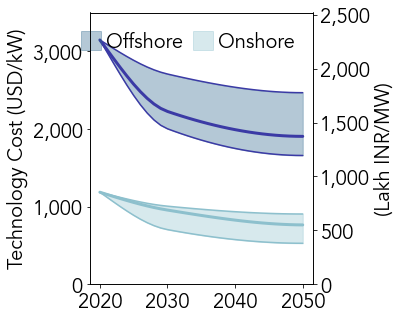

In [52]:
def _plot_wind_cost(ax, df_, 
                    ylabel  = r'Technology Cost (USD/kW)',
                    yplabel = r'(Lakh INR/MW)', 
                    xlabel  = True):

    idx_on_low_  = (df_['scenario'] == 'WDlow') & (df_['technology'] == 'Wind')
    idx_on_mid_  = (df_['scenario'] == 'WDmid') & (df_['technology'] == 'Wind')
    idx_on_high_ = (df_['scenario'] == 'WDhigh') & (df_['technology'] == 'Wind')

    idx_off_low_  = (df_['scenario'] == 'WDlow') & (df_['technology'] == 'Offshore')
    idx_off_mid_  = (df_['scenario'] == 'WDmid') & (df_['technology'] == 'Offshore')
    idx_off_high_ = (df_['scenario'] == 'WDhigh') & (df_['technology'] == 'Offshore')


    ax.plot(df_.loc[idx_off_low_, 'vintage'], df_.loc[idx_off_low_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_off_mid_, 'vintage'], df_.loc[idx_off_mid_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_off_high_, 'vintage'], df_.loc[idx_off_high_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_off_mid_, 'vintage'], 
                    df_.loc[idx_off_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_off_high_, 'capital_real_cost_per_kw'], 
                    color = '#2a648a', alpha = 0.35, label = 'Offshore')
    
    ax.plot(df_.loc[idx_on_low_, 'vintage'], df_.loc[idx_on_low_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_on_mid_, 'vintage'], df_.loc[idx_on_mid_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_on_high_, 'vintage'], df_.loc[idx_on_high_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_on_mid_, 'vintage'], 
                    df_.loc[idx_on_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_on_high_, 'capital_real_cost_per_kw'], 
                    color = '#8dc0cd', alpha = 0.35, label = 'Onshore')
    
    ax.legend(loc     = 'upper right',
              ncol    = 2,
              frameon = False,
              prop    = {'size': 20},
              handletextpad = 0.25,
              columnspacing = 0.5)

    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 3500)
    axp.set_ylim(0, 3500*USD_to_INR*1000/1e5)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)


fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_wind_cost(ax, new_wind_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

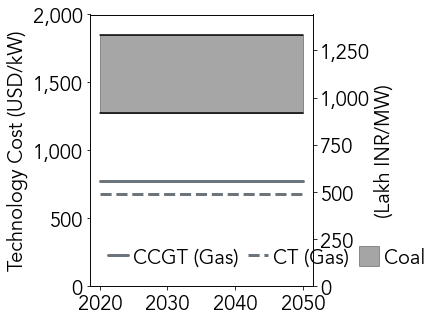

In [53]:
def _plot_convectional_cost(ax, df_,
                            ylabel  = r'Technology Cost (USD/kW)',
                            yplabel = r'(Lakh INR/MW)',
                            xlabel  = True):
    
    idx_coal_low_  = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'Supercritical_Coal')
    idx_coal_high_ = (df_['scenario'] == 'CONVhigh') & (df_['technology'] == 'Supercritical_Coal')

    idx_ccgt_  = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'CCGT')
    idx_ct_ = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'CT')

    ax.plot(df_.loc[idx_ccgt_, 'vintage'], df_.loc[idx_ccgt_, 'capital_real_cost_per_kw'], 
            color = '#6c757d', lw = 3, solid_capstyle='round', label = 'CCGT (Gas)')

    ax.plot(df_.loc[idx_ct_, 'vintage'], df_.loc[idx_ct_, 'capital_real_cost_per_kw'], 
            color = '#6c757d', lw = 3, solid_capstyle='round', ls = '--', label = 'CT (Gas)')
    

    ax.plot(df_.loc[idx_coal_low_, 'vintage'], df_.loc[idx_coal_low_, 'capital_real_cost_per_kw'], 
            color = 'k', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_coal_high_, 'vintage'], df_.loc[idx_coal_high_, 'capital_real_cost_per_kw'], 
            color = 'k', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_coal_low_, 'vintage'], 
                    df_.loc[idx_coal_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_coal_high_, 'capital_real_cost_per_kw'], 
                    color = 'k', alpha = 0.35, label = 'Coal')
    
    
    ax.legend(loc     = 'lower left',
              frameon = False,
              ncol    = 3,
              prop    = {'size': 20}, 
              handletextpad = 0.25,
              columnspacing = 0.5)
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim(0, 2000)
    axp.set_ylim(0, 2000*USD_to_INR*1000/1e5)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

    
fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_convectional_cost(ax, new_conventional_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

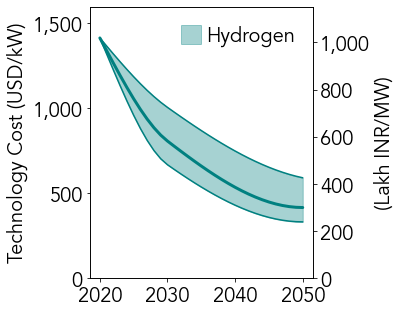

In [54]:
def _plot_hydrogen_power_cost(ax, df_,
                              ylabel  = r'Technology Cost (USD/kW)',
                              yplabel = r'(Lakh INR/MW)',
                              xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = 'teal', alpha = 0.35, label = 'Hydrogen')
    
    # ax.xaxis.set_tick_params(labelsize = 14)
    # ax.yaxis.set_tick_params(labelsize = 14)
    # ax.set_ylabel(ylabel, fontsize = 16)
    # ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.legend(loc     = 'upper right',
              ncol    = 2,
              frameon = False,
              prop    = {'size': 20},
              handletextpad = 0.25,
              columnspacing = 0.5)
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 1600)
    axp.set_ylim(0, 1600*USD_to_INR*1000/1e5)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_hydrogen_power_cost(ax, new_hydrogen_cavern_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

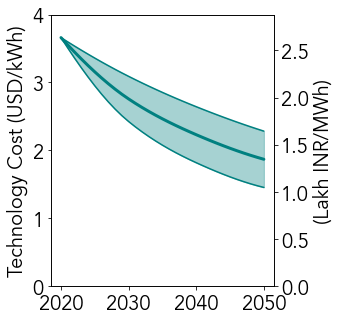

In [55]:
def _plot_hydrogen_energy_cost(ax, df_,
                               ylabel  = r'Technology Cost (USD/kWh)',
                               yplabel = r'(Lakh INR/MWh)',
                               xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'], 
            color = 'teal', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
                    color = 'teal', alpha = 0.35, label = 'Tank')
    
#     idx_low_  = df_['scenario'] == 'STlow'
#     idx_mid_  = df_['scenario'] == 'STmid'
#     idx_high_ = df_['scenario'] == 'SThigh'
    
#     # ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
#     #         color = 'teal', lw = 1.5)
#     ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'], 
#             color = 'teal',  lw = 3, label = 'Cavern', solid_capstyle='round')
#     # ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
#     #         color = 'teal', lw = 1.5)
    
    # ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
    #                 df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
    #                 df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
    #                 color = 'teal', alpha = 0.35, label = 'Hydrogen')
    
    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.legend(loc     = 'upper right',
#               frameon = False,
#               prop    = {'size': 14})
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    #axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 4.)
    axp.set_ylim(0, 4.*USD_to_INR*1000/1e5)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_hydrogen_energy_cost(ax, new_hydrogen_cavern_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

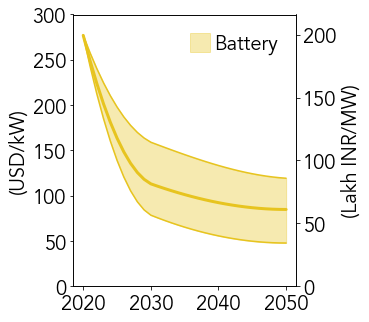

In [56]:
def _plot_battery_power_cost(ax, df_, 
                             ylabel  = r'(USD/kW)', 
                             yplabel = r'(Lakh INR/MW)',
                             xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'],
            color = '#e7c41f', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'],
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = '#e7c41f', alpha = 0.35, label = 'Battery')
    
    ax.legend(loc     = 'upper right',
              ncol    = 2,
              frameon = False,
              prop    = {'size': 20},
              handletextpad = 0.25,
              columnspacing = 0.5)
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 300)
    axp.set_ylim(0, 300*USD_to_INR*1000/1e5)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_battery_power_cost(ax, new_battery_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

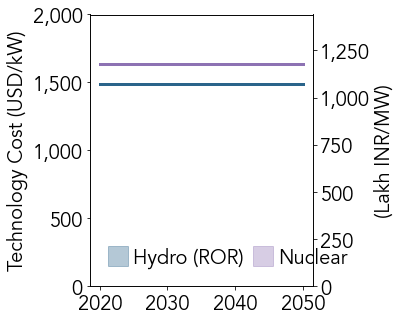

In [57]:
def _plot_nuclear_cost(ax, df_, hydro_ROR = 1486.11,
                       ylabel  = r'Technology Cost (USD/kW)', 
                       yplabel = r'(Lakh INR/MW)',
                       xlabel  = True):
    
    idx_nuclear_ = (df_['scenario'] == 'NUCLmid') & (df_['technology'] == 'Nuclear')

    ax.plot(df_.loc[idx_nuclear_, 'vintage'], hydro_ROR*np.ones(df_.loc[idx_nuclear_, 'vintage'].shape[0]), 
            color = '#2a648a', lw = 3)
    
    ax.fill_between(df_.loc[idx_nuclear_, 'vintage'], 
                    hydro_ROR*np.ones(df_.loc[idx_nuclear_, 'vintage'].shape[0]),
                    hydro_ROR*np.ones(df_.loc[idx_nuclear_, 'vintage'].shape[0]), 
                    color = '#2a648a', alpha = 0.35, label = 'Hydro (ROR)')
    
    
    ax.plot(df_.loc[idx_nuclear_, 'vintage'], df_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
            color = '#8d72b3', lw = 3)
    
    ax.fill_between(df_.loc[idx_nuclear_, 'vintage'], 
                    df_.loc[idx_nuclear_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
                    color = '#8d72b3', alpha = 0.35, label = 'Nuclear')
    
    ax.legend(loc     = 'lower left',
              ncol    = 2,
              frameon = False,
              prop    = {'size': 20},
              handletextpad = 0.25,
              columnspacing = 0.5)
    
    axp = ax.twinx()
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 2000)
    axp.set_ylim(0, 2000*USD_to_INR*1000/1e5)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)


fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_nuclear_cost(ax, new_nuclear_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

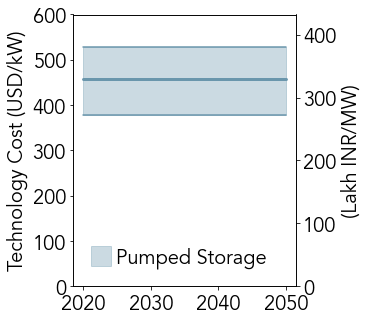

In [58]:
def _plot_phs_power_cost(ax, df_,
                         ylabel  = r'Technology Cost (USD/kW)', 
                         yplabel = r'(Lakh INR/MW)', 
                         xlabel = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'],
            color = '#6a96ac', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'],
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = '#6a96ac', alpha = 0.35, label = 'Pumped Storage')
    
#     idx_nuclear_ = (df_1_['scenario'] == 'NUCLmid') & (df_1_['technology'] == 'Nuclear')

#     ax.plot(df_1_.loc[idx_nuclear_, 'vintage'], df_1_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
#             color = '#8d72b3', lw = 3, label = 'Nuclear')
    
    ax.legend(loc     = 'lower left',
              ncol    = 2,
              frameon = False,
              prop    = {'size': 20},
              handletextpad = 0.25,
              columnspacing = 0.5)
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim(0, 600)
    axp.set_ylim(0, 600*USD_to_INR*1000/1e5)

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_phs_power_cost(ax, new_hydro_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

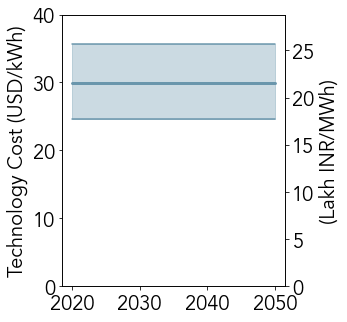

In [59]:
def _plot_phs_energy_cost(ax, df_, 
                          ylabel  = r'Technology Cost (USD/kWh)', 
                          yplabel = r'(Lakh INR/MWh)',
                          xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'],
            color = '#6a96ac', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'],
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
                    color = '#6a96ac', alpha = 0.35, label = 'Pumped Hydro')
    
    # ax.legend(loc     = 'upper right',
    #           frameon = False,
    #           prop    = {'size': 14})
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()
    
    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    axp.yaxis.set_tick_params(labelsize = 20)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)

    ax.set_ylim(0, 40)
    axp.set_ylim(0, 40*USD_to_INR*1000/1e5)

    #axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_phs_energy_cost(ax, new_hydro_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

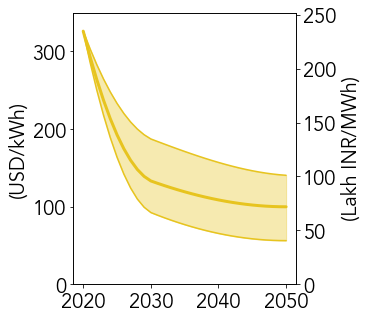

In [60]:
def _plot_battery_energy_cost(ax, df_, 
                              ylabel  = r'(USD/kWh)', 
                              yplabel = r'(Lakh INR/MWh)',
                              xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'],
            color = '#e7c41f', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'],
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'],  
                    color = '#e7c41f', alpha = 0.35, label = 'Battery')
    
#     ax.legend(loc     = 'upper right',
#               frameon = False,
#               prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 20)
    ax.yaxis.set_tick_params(labelsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    
    ax.set_ylim(0, 350)
    
    x_ = np.array([2020, 2030, 2040, 2050])
    ax.set_xticks(x_, x_, fontsize = 20)
    
    axp = ax.twinx()
    
    axp.set_ylim(0, 350*USD_to_INR*1000/1e5)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_battery_energy_cost(ax, new_battery_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

In [61]:
# fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e']],
#                               layout      = 'constrained', 
#                               figsize     = (20, 5), 
#                               gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1]})

# for label, ax in _ax.items():
#     ax.text(0.0, 1.0, label, 
#             transform = ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
#             fontsize  = 'xx-large', 
#             weight    = "bold",
#             va        = 'bottom',
#             family    = 'Arial')
    
# _plot_convectional_cost(_ax['a'], new_conventional_costs_all, yplabel = '')

# _plot_solar_cost(_ax['b'], new_solar_costs_all, ylabel = '', yplabel = '')

# _plot_wind_cost(_ax['c'], new_wind_costs_all, ylabel = '', yplabel = '')

# _plot_battery_power_cost(_ax['d'], new_battery_costs_all, ylabel = '', yplabel = '')
# _plot_hydrogen_power_cost(_ax['e'], new_hydrogen_cavern_costs_all, ylabel = '')

# # plt.savefig(path_to_images + f'/demand_profiles-{method}.pdf', 
# #             bbox_inches = 'tight', 
# #             dpi         = 600)

# plt.savefig(path_to_images + f'/technology_costs.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

# plt.show()

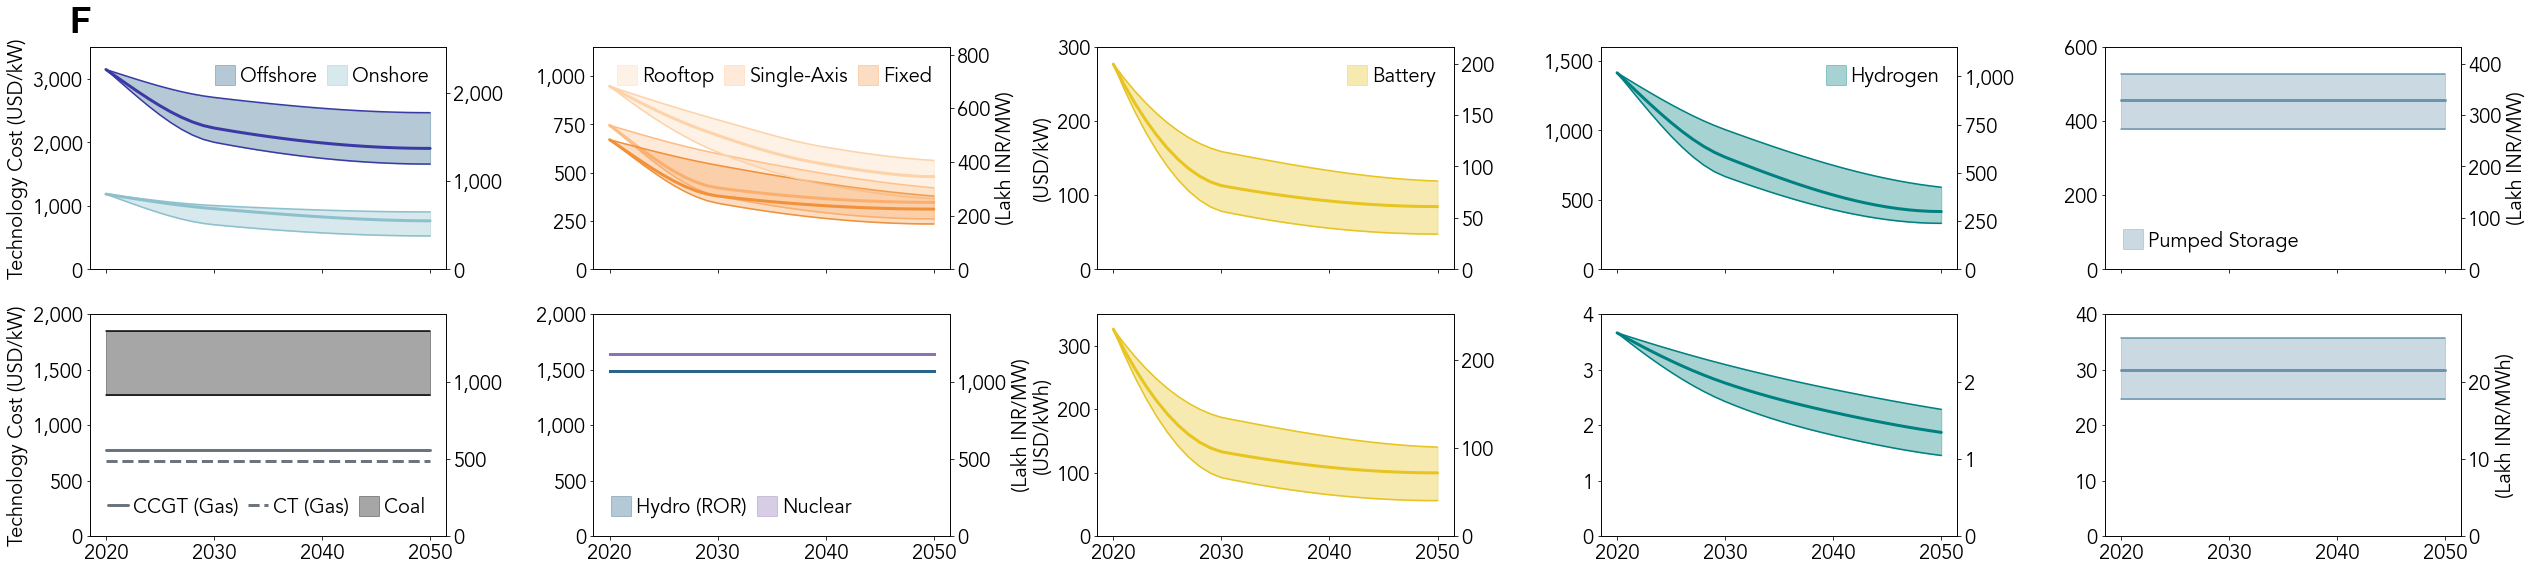

In [62]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C', 'D', 'E'],
                               ['F', 'G', 'H', 'I', 'J']],
                              sharex      = True,
                              figsize     = (42.5, 9.), 
                              gridspec_kw = {'wspace': 0.4125,
                                             'width_ratios': [1, 1, 1, 1, 1]})


_ax['A'].text(0.0, 1.0, 'F', 
        transform = _ax['A'].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
        fontsize  = 36, 
        weight    = "bold",
        va        = 'bottom',
        family    = 'Arial')
    

_plot_solar_cost(_ax['B'], new_solar_costs_all, ylabel = '')

_plot_wind_cost(_ax['A'], new_wind_costs_all, yplabel = '')

_plot_battery_power_cost(_ax['C'], new_battery_costs_all, yplabel = '')

_plot_hydrogen_power_cost(_ax['D'], new_hydrogen_cavern_costs_all, ylabel = '', yplabel = '')

_plot_phs_power_cost(_ax['E'], new_hydro_costs_all, ylabel = '')

_plot_convectional_cost(_ax['F'], new_conventional_costs_all, yplabel = '')

_plot_nuclear_cost(_ax['G'], new_nuclear_costs_all, ylabel = '')

_plot_battery_energy_cost(_ax['H'], new_battery_costs_all, yplabel = '')

_plot_hydrogen_energy_cost(_ax['I'], new_hydrogen_cavern_costs_all, ylabel = '', yplabel = '')

_plot_phs_energy_cost(_ax['J'], new_hydro_costs_all, ylabel = '')

plt.savefig(path_to_images + f'/overview-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + f'/overview-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Capacity and Transmission

In [28]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv')
print(tech_labels_)

                  group              technology group_color    color  order  \
0                  Coal  Subcritical_Coal_Large     #343a40  #343a40      1   
1                  Coal  Subcritical_Coal_Small     #343a40  #343a40      1   
2                  Coal      Supercritical_Coal     #343a40  #343a40      1   
3                   Gas                    CCGT     #6c757d  #6c757d      2   
4                   Gas                      CT     #6c757d  #6c757d      2   
5                Diesel                  Diesel     #924B00  #924B00      3   
6                 Hydro               Hydro_ROR     #2a648a  #2a648a      6   
7                 Hydro           Hydro_Storage     #2a648a  #2a648a      6   
8                 Other                 Biomass     #6ba661  #6a96ac      5   
9                 Other                     WHR     #6ba661  #6ba661      5   
10             Hydrogen                Hydrogen        teal     teal     11   
11              Battery                 Battery     

In [29]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
       
    #capacity_.loc[capacity_['technology'] == 'Pumped Storage', 'technology'] = 'Hydro'
    capacity_ = capacity_.groupby(['technology', 
                                   'load_zone']).agg({'capacity_mw': 'sum'})

    return capacity_.reset_index(drop = False)

path_to_scen = '/Users/Guille/Desktop/india_power/scenarios/cost/VREmid_STmid_CONVmid_H2_RES_8PRM_CC_50RPS_90CAP_500GW_PIERmid/inputs/'

tx_                   = pd.read_csv(path_to_scen + 'specified_transmission_line_capacities.tab', sep = '\t')
tx_['load_zone_from'] = tx_['transmission_line'].apply(lambda x: x.split('-')[0])
tx_['load_zone_to']   = tx_['transmission_line'].apply(lambda x: x.split('-')[1])
tx_                   = tx_.loc[tx_['period'] == 2020].reset_index(drop = True)
tx_                   = tx_[['specified_tx_max_mw', 'load_zone_from', 'load_zone_to']]
tx_                   = tx_.rename(columns = {'specified_tx_max_mw': 'max_mw'})

tx_.loc[tx_['load_zone_to'] == 'Daman_Diu', 'load_zone_to']     = 'Dadra_Nagar_Haveli'
tx_.loc[tx_['load_zone_from'] == 'Daman_Diu', 'load_zone_from'] = 'Dadra_Nagar_Haveli'

tx_ = tx_.groupby(['load_zone_from', 'load_zone_to']).agg('sum').reset_index(drop = False)
        
cap_ = pd.read_csv(path_to_scen + 'spec_capacity_period_params.tab', sep = '\t')
cap_ = cap_.loc[cap_['period'] == 2020].reset_index(drop = True)
cap_ = cap_[['project', 'specified_capacity_mw']].set_index('project')

proj_ = pd.read_csv(path_to_scen + 'projects.tab', sep = '\t')
proj_ = proj_[['project', 'technology', 'load_zone']].set_index('project')

cap_['technology'] = proj_.loc[cap_.index, ['technology']]
cap_['load_zone']  = proj_.loc[cap_.index, ['load_zone']]
cap_               = cap_.reset_index(drop = True)
cap_               = cap_.rename(columns = {'specified_capacity_mw': 'capacity_mw'})

cap_.loc[cap_['load_zone'] == 'Daman_Diu', 'load_zone'] = 'Dadra_Nagar_Haveli'

cap_ = cap_.groupby(['capacity_mw', 'technology', 'load_zone']).agg('sum').reset_index(drop = False)
#print(cap_)

group_cap_ = _group_capacity_technologies(cap_, tech_labels_)

In [30]:
def _opt_dist(x_, y_, d = 1.4, delta = 0.1):
    
    def __update_position(x, x_0, z):
        return x + ((x - x_0)/z)*delta, x_0 + ((x_0 - x)/z)*delta  
    
    while True:
        flag = True
        for i in range(x_.shape[0]):
            for j in range(x_.shape[0]):
                if i != j:
                    z = np.sqrt( (x_[j] - x_[i])**2 + (y_[j] - y_[i])**2 )
                    if z < d:
                        x_[j], x_[i] = __update_position(x_[j], x_[i], z)
                        y_[j], y_[i] = __update_position(y_[j], y_[i], z)
                        flag = False
        if flag:
            break

    return x_, y_

path_to_data = '/Users/Guille/Desktop/india_power/gridpath_india_viz/data/'

_india  = gpd.read_file(path_to_data + r"map/india/india-polygon.shp").to_crs("epsg:4326")
_bhutan = gpd.read_file(path_to_data + r"map/bhutan/bt.shp").to_crs("epsg:4326")

_nothern      = _india.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
_northeastern = _india.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
_western      = _india.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
_southern     = _india.loc[[13, 14, 23, 27, 28, 34]].dissolve()
_eastern      = _india.loc[[3, 12, 26, 32, 33]].dissolve()
_regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)

city_ = pd.read_csv(path_to_input + r"transmission/major_cities_india.csv")
city_ = city_.drop(columns = ['state', 'major_city'])
city_ = city_.rename(columns = {'acronym': 'load_zone_abr'})

<ipython-input-30-942e0a58ce54>:26: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _nothern      = _india.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")


In [31]:
total_cap_                = group_cap_[['load_zone', 'capacity_mw']].groupby(['load_zone']).agg('sum').reset_index(drop = False)
total_cap_['capacity_gw'] = (total_cap_['capacity_mw']/1000.).round(2)
total_cap_['position']    = 1

total_cap_.loc[15, 'position'] = 0
total_cap_.loc[25, 'position'] = 0
total_cap_.loc[5, 'position']  = 1
total_cap_.loc[6, 'position']  = 0
total_cap_.loc[14, 'position'] = 0
total_cap_.loc[30, 'position'] = 0
total_cap_.loc[2, 'position']  = 0
total_cap_.loc[10, 'position'] = 0
total_cap_.loc[26, 'position'] = 0
total_cap_.loc[27, 'position'] = 0
total_cap_.loc[3, 'position']  = 2
total_cap_.loc[2, 'position']  = 2
total_cap_.loc[11, 'position'] = 2
print(total_cap_)

load_zones_ = pd.read_csv(path_to_input + r"/load_zones.csv").drop(columns = ['state', 'rps_zone'])
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')
load_zones_p_ = load_zones_.copy()

load_zones_p_['longitude'], load_zones_p_['latitude'] = _opt_dist(load_zones_p_['longitude'].to_numpy(), load_zones_p_['latitude'].to_numpy())
               
# load_zones_p_.loc[31, 'latitude'] = load_zones_.loc[31, 'latitude']
# load_zones_p_.loc[7, 'latitude']  = load_zones_.loc[7, 'latitude']
    
# load_zones_p_.loc[13, 'latitude']  -= .1
# load_zones_p_.loc[15, 'longitude'] -= .175
# load_zones_p_.loc[29, 'longitude'] -= .4
# load_zones_p_.loc[30, 'longitude'] += .15
# load_zones_p_.loc[34, 'latitude']  += .325
# load_zones_p_.loc[34, 'longitude'] += .5

# load_zones_p_.loc[7, 'latitude']  += 1.25
# load_zones_p_.loc[7, 'longitude'] -= 1.625

# load_zones_p_.loc[28, 'latitude']  += .5
# load_zones_p_.loc[28, 'longitude'] -= .125

# load_zones_p_.loc[26, 'latitude']  -= .5
# load_zones_p_.loc[26, 'longitude'] += .25

# load_zones_p_.loc[19, 'latitude']  += .25
# load_zones_p_.loc[19, 'longitude'] -= .25

# load_zones_p_.loc[8, 'longitude'] += .25

# load_zones_p_.loc[24, 'longitude'] -= .1
# #load_zones_p_.loc[19, 'longitude'] -= .1
# load_zones_p_.loc[16, 'longitude'] += .125

# print(load_zones_p_)

load_zones_p_.loc[31, 'latitude'] = load_zones_.loc[31, 'latitude']
load_zones_p_.loc[7, 'latitude']  = load_zones_.loc[7, 'latitude']
    
load_zones_p_.loc[31, 'latitude']  += .05
load_zones_p_.loc[31, 'longitude'] += .15

load_zones_p_.loc[13, 'latitude']  -= .1
load_zones_p_.loc[15, 'longitude'] -= .175
load_zones_p_.loc[29, 'longitude'] -= .6
load_zones_p_.loc[29, 'latitude'] -= .15

#load_zones_p_.loc[30, 'longitude'] += .5
load_zones_p_.loc[34, 'latitude']  += .325
load_zones_p_.loc[34, 'longitude'] += .5

load_zones_p_.loc[7, 'latitude']  += 1.1
load_zones_p_.loc[7, 'longitude'] -= 1.55

load_zones_p_.loc[28, 'latitude']  += .4
#load_zones_p_.loc[28, 'longitude'] -= .125

#load_zones_p_.loc[26, 'latitude']  += .2
load_zones_p_.loc[26, 'longitude'] += .7

#load_zones_p_.loc[19, 'latitude']  += .1
load_zones_p_.loc[19, 'longitude'] -= .3

load_zones_p_.loc[8, 'longitude'] += .25

load_zones_p_.loc[13, 'latitude']  -= .15
load_zones_p_.loc[13, 'longitude'] += .15

load_zones_p_.loc[16, 'longitude'] += .125

print(load_zones_p_)

             load_zone  capacity_mw  capacity_gw  position
0       Andhra_Pradesh    20210.832        20.21         1
1    Arunachal_Pradesh      516.000         0.52         1
2                Assam     1924.515         1.92         2
3               Bhutan     2326.000         2.33         2
4                Bihar     6030.200         6.03         1
5           Chandigarh       14.400         0.01         1
6         Chhattisgarh    29719.638        29.72         0
7   Dadra_Nagar_Haveli       32.400         0.03         1
8                Delhi     2208.400         2.21         1
9                  Goa       85.320         0.09         1
10             Gujarat    32432.415        32.43         0
11             Haryana     6426.550         6.43         2
12    Himachal_Pradesh     9859.320         9.86         1
13       Jammu_Kashmir     3633.000         3.63         1
14           Jharkhand     6023.920         6.02         0
15           Karnataka    22235.421        22.24        

50.0 20933.0


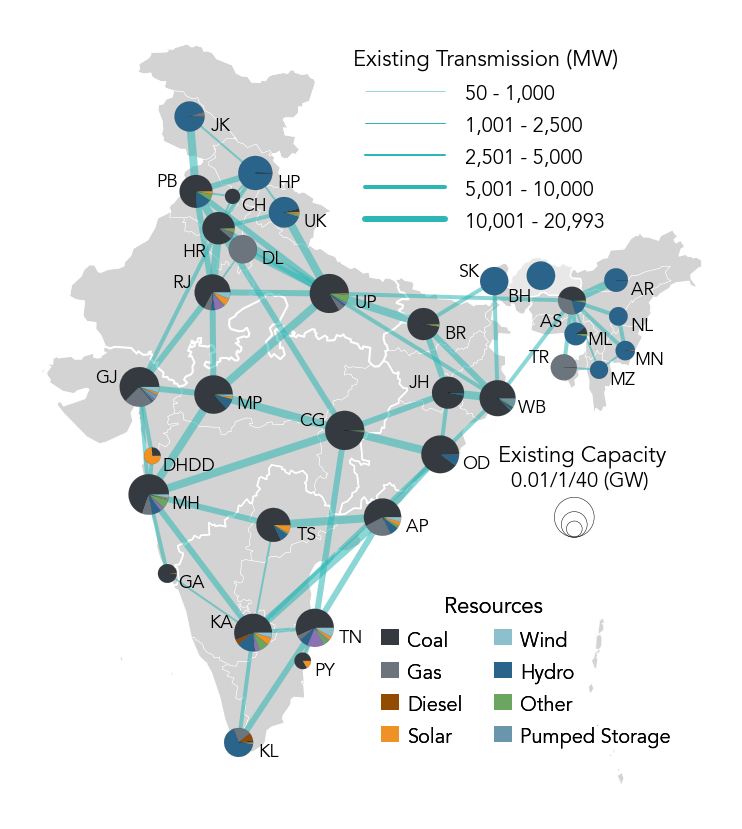

In [32]:
def _plot_specified_capacity(ax, tx_, group_cap_, total_cap_, load_zones_):

    def __f(total):
        return np.sqrt(np.sqrt(np.sqrt(total/1e3)))/2.25
    
    print(tx_['max_mw'].min(), tx_['max_mw'].max())
    for i in range(tx_.shape[0]):

        load_zone_to_   = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_to']]
        load_zone_from_ = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_from']]

        x_ = np.concatenate([load_zone_from_['latitude'].to_numpy(), load_zone_to_['latitude'].to_numpy()], axis = 0)
        y_ = np.concatenate([load_zone_from_['longitude'].to_numpy(), load_zone_to_['longitude'].to_numpy()], axis = 0)

        #z = np.sqrt(np.absolute(tx_.loc[i, 'tx_mw'])/1e3)

        if tx_.loc[i, 'max_mw'] < 1000.:
            ax.plot(y_, x_, lw             = 2., 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if (tx_.loc[i, 'max_mw'] < 5000.) & (tx_.loc[i, 'max_mw'] >= 1000.):
            ax.plot(y_, x_, lw             = 4, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if (tx_.loc[i, 'max_mw'] < 10000.) & (tx_.loc[i, 'max_mw'] >= 5000.):
            ax.plot(y_, x_, lw             = 6, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if tx_.loc[i, 'max_mw'] >= 10000.:
            ax.plot(y_, x_, lw             = 8, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    for i in range(total_cap_.shape[0]):

        load_zone_ = load_zones_.loc[load_zones_['load_zone'] == total_cap_.loc[i, 'load_zone']]
        cap_       = group_cap_.loc[group_cap_['load_zone'] == total_cap_.loc[i, 'load_zone'], ['technology', 'capacity_mw']]
        abr        = load_zone_['load_zone_abr'].to_numpy()[0]
        total      = total_cap_.loc[i, 'capacity_mw']
        totalp     = int(total)
        width      = __f(total)

        axp_ = inset_axes(ax, width          = width, 
                              height         = width, 
                              bbox_to_anchor = (load_zone_['longitude'], load_zone_['latitude']),
                              loc            = 10, 
                              bbox_transform = ax.transData, 
                              borderpad      = 0)
        
#         x = 0
#         if len(str(totalp)) < 3:
#             x = -6
#         if len(str(totalp)) > 3:
#             x = 4
#         if len(str(totalp)) > 4:
#             x = 8
            
#         if total_cap_.loc[i, 'position'] == 0:
#             axp_.set_ylabel(f'{totalp:,}', fontsize = 17, labelpad = 14 + x, rotation = 0)
#         if total_cap_.loc[i, 'position'] == 1:
#             axp_.set_ylabel(f'{totalp:,}', fontsize = 17, labelpad = 14 + x, rotation = 0)
#             axp_.yaxis.set_label_position('right') 
#         if total_cap_.loc[i, 'position'] == 2:
#             axp_.set_xlabel(f'{totalp:,}', fontsize = 17, labelpad = -1.5, x = -.5)
#         if total_cap_.loc[i, 'position'] == 3:
#             axp_.set_xlabel(f'{totalp:,}', fontsize = 17, labelpad = -1.5)
#             axp_.xaxis.set_label_position('top') 

        if total_cap_.loc[i, 'position'] == 0:
            axp_.set_ylabel(f'{abr}', fontsize = 18, labelpad = 8, rotation = 0)
        if total_cap_.loc[i, 'position'] == 1:
            if abr == 'ML':
                axp_.set_ylabel(f'{abr}', fontsize = 18, labelpad = 10, rotation = 0, y = .65)
            elif abr == 'DH':
                axp_.set_ylabel(f'DHDD', fontsize = 18, labelpad = 26, rotation = 0)
            elif abr == 'OR':
                axp_.set_ylabel(f'OD', fontsize = 18, labelpad = 12, rotation = 0)
            else:
                axp_.set_ylabel(f'{abr}', fontsize = 18, labelpad = 12, rotation = 0)
            axp_.yaxis.set_label_position('right') 
        if total_cap_.loc[i, 'position'] == 2:
            if (abr == 'AS') | (abr == 'BH') | (abr == 'HR'):
                axp_.set_xlabel(f'{abr}', fontsize = 18, labelpad = -6, x = -.1)
            else:
                axp_.set_xlabel(f'{abr}', fontsize = 18, labelpad = -6, x = -.5)
        if total_cap_.loc[i, 'position'] == 3:
            axp_.set_xlabel(f'{abr}', fontsize = 18, labelpad = -1.5)
            axp_.xaxis.set_label_position('top') 
            
        axp_.pie(cap_['capacity_mw']/total,
                 wedgeprops = {'edgecolor': 'black', 'linewidth': .1}, 
                 colors     = [tech_labels_.loc[tech_labels_['group'] == tech, 'group_color'].to_numpy()[0] for tech in cap_['technology']])

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _bhutan.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 1.5, alpha = .5, edgecolor = 'white')
    _india.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')

    x = 20.
    y = 7.5

    ax.scatter(71.75 + x, 10.2 + y, s = 2250*__f(40000), zorder = 10, c = 'None', edgecolor = 'k', lw = .5)
    ax.scatter(71.75 + x, 9.9 + y, s = 1500*__f(1000), zorder = 10, c = 'None', edgecolor = 'k', lw = .5)
    ax.scatter(71.75 + x, 9.72 + y, s = 1000*__f(10), zorder = 10, c = 'None', edgecolor = 'k', lw = .5)

    ax.annotate('Existing Capacity', (68.4 + x, 12.5 + y), fontsize = 22)
    ax.annotate('0.01/1/40 (GW)', (68.95 + x, 11.5 + y), fontsize = 20)
    #ax.annotate('', (70.7 + x, 10.55 + y), fontsize = 15)
    #ax.annotate('1', (71 + x, 9.9 + y), fontsize = 15)
    
#     axp_ = inset_axes(ax, width          = .75, 
#                           height         = .75, 
#                           bbox_to_anchor = (87.5, 12.5),
#                           loc            = 10, 
#                           bbox_transform = ax.transData, 
#                           borderpad      = 0)

#     axp_.set_title('Existing Capacity (MW)', size = 20, y = 1.375)
#     axp_.pie([1, 1, 1, 1, 1, 1, 1], 
#              wedgeprops    = {'edgecolor': 'black', 'linewidth': .1},
#              colors        = ['#343a40', '#6c757d', '#924B00', '#ef9226', '#8dc0cd', '#6ba661', '#2a648a'],
#              labels        = ['Coal', 'Gas', 'Disel', 'Solar', 'Wind', 'Other', 'Hydro'], 
#              labeldistance = 1.5, 
#              textprops     = {'fontsize': 18})
    # #95cca3 #2cb7b5
    line1 = Line2D([], [], color = '#2cb7b5', lw = .5, solid_capstyle ='round')
    line2 = Line2D([], [], color = '#2cb7b5', lw = 1, solid_capstyle ='round')
    line3 = Line2D([], [], color = '#2cb7b5', lw = 2, solid_capstyle ='round')
    line4 = Line2D([], [], color = '#2cb7b5', lw = 4, solid_capstyle ='round')
    line5 = Line2D([], [], color = '#2cb7b5', lw = 6, solid_capstyle ='round')

    legend1 = ax.legend((line1, line2, line3, line4, line5), 
                        ('50 - 1,000', 
                         '1,001 - 2,500', 
                         '2,501 - 5,000', 
                         '5,001 - 10,000',
                         '10,001 - 20,993'), 
                        
               title_fontsize = 22,
               title          = 'Existing Transmission (MW)',
               handlelength   = 4.,
               handletextpad  = 1.,
               labelspacing   = .5,
               frameon        = False, 
               bbox_to_anchor = (0.45, 0.7), 
               prop           = {'size': 20})
    
    s0 = Line2D([], [], color = '#343a40', lw = 16)
    s1 = Line2D([], [], color = '#6c757d', lw = 16)
    s2 = Line2D([], [], color = '#924B00', lw = 16)
    s3 = Line2D([], [], color = '#ef9226', lw = 16)
    s4 = Line2D([], [], color = '#8dc0cd', lw = 16)
    s5 = Line2D([], [], color = '#2a648a', lw = 16)
    s6 = Line2D([], [], color = '#6ba661', lw = 16)
    s7 = Line2D([], [], color = '#6a96ac', lw =  16)

    x_ = (s0, s1, s2, s3, s4, s5, s6, s7)
    y_ = ('Coal', 'Gas', 'Diesel', 'Solar', 'Wind',  'Hydro', 'Other', 'Pumped Storage')
    
    legend2 = ax.legend(x_, y_,
                        title          = r'Resources            ',
                        title_fontsize = 22,
                        handlelength   = .1,
                        ncol           = 2,
                        bbox_to_anchor = (.5, .3),
                        frameon        = False,
                        prop           = {'size': 20})
    
    ax.add_artist(legend1)
    ax.add_artist(legend2)

fig, ax = plt.subplots(1, 1, figsize = (14, 15))

_plot_specified_capacity(ax, tx_, group_cap_, total_cap_, load_zones_p_)

plt.savefig(path_to_images + '/existing_capacity.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Solar Resource

In [33]:
# _india = gpd.read_file(path_to_data + r"map/india/india-polygon.shp").to_crs("epsg:4326")
# #_map = _map.drop([0, 15])

# _nothern      = _india.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
# _northeastern = _india.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
# _western      = _india.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
# _southern     = _india.loc[[13, 14, 23, 27, 28, 34]].dissolve()
# _eastern      = _india.loc[[3, 12, 26, 32, 33]].dissolve()
# _regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)

In [34]:
# path_to_data = '/Users/Guille/Desktop/india_power/data/'
# path_to_cfs  = '/Users/Guille/Desktop/india_power/data/vre-climate-data/capacity_factors/'

# solar_    = gpd.read_file(path_to_data + 'mapre/base2022_solar.gdb', driver='fileGDB', layer='india_zones_combined_100km', ignore_geometry = False)
# solar_crs = solar_.crs

In [35]:
path_to_data = '/Users/Guille/Desktop/india_power/data/'
path_to_cfs  = '/Users/Guille/Desktop/india_power/data/vre-climate-data/capacity_factors/'

solar_    = gpd.read_file(path_to_data + 'mapre/base2022_solar.gdb', driver='fileGDB', layer='india_zones_combined_100km', ignore_geometry = False)
solar_crs = solar_.crs
solar_    = solar_[['state_zone', 'geometry']].rename(columns = {'state_zone': 'project'}).set_index('project')
solar_p_  = pd.read_csv(path_to_data + 'vre-climate-data/selected-zones/solar_base_project_capacity_2025.csv')[['project', 'capacity_mw']]
solar_    = pd.merge(solar_.loc[solar_p_['project']], solar_p_, on = 'project')

for i in range(solar_.shape[0]):
    project             = solar_.loc[i, 'project']
    solar_.loc[i, 'cf'] = pd.read_csv(path_to_cfs + f'solar/solar_single/cf_solar_{project}_2017_2019_meteosat_sam_singleAxis.csv')['capacity_factor'].mean()

KeyboardInterrupt: 

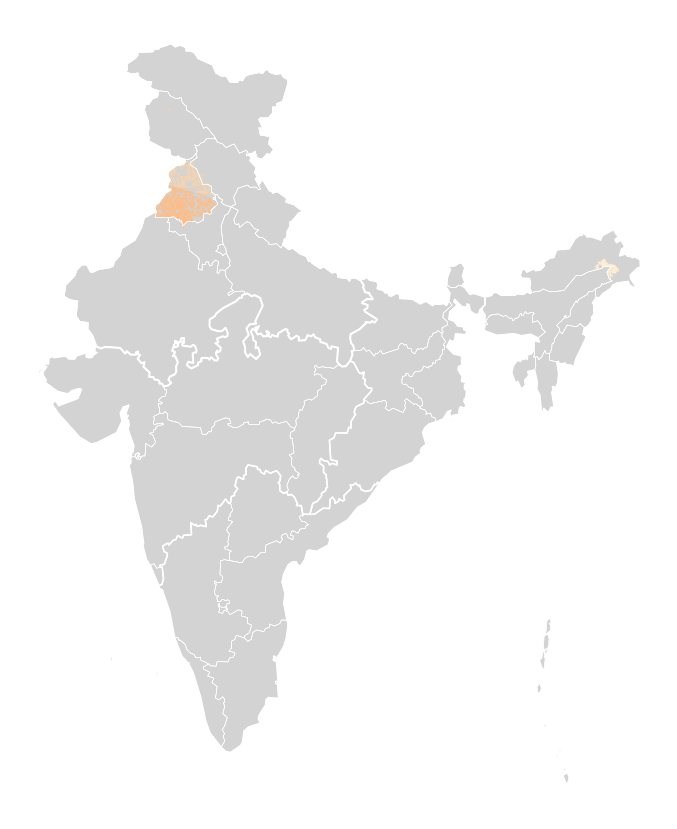

In [36]:
def _plot_solar_resource(ax, df_, crs):

    _nothern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _india.plot(ax = ax, zorder = 7, color = 'lightgray', lw = 0.5, edgecolor = 'white')
    _india.plot(ax = ax, zorder = 9, color = 'None', lw = 0.5, edgecolor = 'white')

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    colors_ = ['#feeed5', '#fdd3aa', '#ffbc85', '#f8a462', '#f19139']
    rule_   = [.17, .18, .19, .20]
    
    for i in range(df_.shape[0]):
        
        if df_.loc[i, 'cf'] < rule_[0]:
            c = colors_[0]
        if (df_.loc[i, 'cf'] >= rule_[0]) & (df_.loc[i, 'cf'] < rule_[1]):
            c = colors_[1]
        if (df_.loc[i, 'cf'] >= rule_[1]) & (df_.loc[i, 'cf'] < rule_[2]):
            c = colors_[2]
        if (df_.loc[i, 'cf'] >= rule_[2]) & (df_.loc[i, 'cf'] < rule_[3]):
            c = colors_[3]
        if df_.loc[i, 'cf'] >= rule_[3]:
            c = colors_[4]
            
        gpd.GeoSeries(so.cascaded_union(df_.loc[i, 'geometry']), crs = crs).to_crs(epsg = 4326).plot(ax     = ax,                                                                                            
                                                                                                     zorder = 7,                                                                                            
                                                                                                     color  = c)
    
    ax.bar(0., 0., 0., color  = colors_[0],
                       label  = r'$<$17%')

    ax.bar(0., 0., 0., color  = colors_[1],
                       label  = '17 - 17.9%')

    ax.bar(0., 0., 0., color  = colors_[2],
                       label  = '18 - 18.9%')

    ax.bar(0., 0., 0., color  = colors_[3],
                       label  = '19 - 19.9%')

    ax.bar(0., 0., 0., color  = colors_[4],
                       label  = r'$\geq$20%')

    ax.legend(loc            = 'center left',
              title          = ' Solar Potential \n Average Capacity \n Factor',
              title_fontsize = 22,
              bbox_to_anchor = (.525, 0.2125),
              frameon        = False,
              prop           = {'size': 20})
    
fig, ax = plt.subplots(1, 1, figsize = (17, 15))

_plot_solar_resource(ax, solar_, solar_crs)

plt.show()

# Wind Resource

In [ ]:
path_to_data = '/Users/Guille/Desktop/india_power/data/'

wind_ = gpd.read_file(path_to_data + 'mapre/base2022_wind.gdb', driver='fileGDB', layer='india_zones_combined_100km', ignore_geometry=False)
wind_ = wind_[['state_zone', 'geometry']].rename(columns = {'state_zone': 'project'}).set_index('project')
wind_crs = wind_.crs

offshore_ = pd.read_csv(path_to_data + 'vre-climate-data/selected-zones/offshore_base_project_capacity_2025-2.csv')[['project', 'capacity_mw', 'capacity_factor', 'geometry']].rename(columns = {'capacity_factor': 'cf'})
wind_p_   = pd.read_csv(path_to_data + 'vre-climate-data/selected-zones/wind_base_project_capacity_2025-2.csv')[['project', 'capacity_mw']]
wind_     = pd.merge(wind_.loc[wind_p_['project']], wind_p_, on = 'project')

for i in range(wind_.shape[0]):
    project            = wind_.loc[i, 'project']
    wind_.loc[i, 'cf'] = pd.read_csv(path_to_cfs + f'wind/wind_new/cf_wind_new_{project}_2017_2019_era5_sam_Vestas_2MW.csv')['capacity_factor'].mean()

for i in range(offshore_.shape[0]):
    project                = offshore_.loc[i, 'project']
    offshore_.loc[i, 'cf'] = pd.read_csv(path_to_cfs + f'wind/offshore/cf_offshore_{project}_2017_2019_era5_sam_Vestas_V164_7MW.csv')['capacity_factor'].mean()

In [ ]:
def _plot_wind_resource(ax, df_1_, df_2_, crs):

    _nothern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 10, color = 'None', lw = 1.5, edgecolor = 'white')
    _india.plot(ax = ax, zorder = 7, color = 'lightgray', lw = 0.5, edgecolor = 'white')
    _india.plot(ax = ax, zorder = 9, color = 'None', lw = 0.5, edgecolor = 'white')

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    colors_ = ['#c3eff1', '#90c2ec', '#4a9ae4', '#4b69c5', '#3b3aa5']
    rule_   = [.22, .25, .28, .31]
    
    for i in range(df_1_.shape[0]):
        
        if df_1_.loc[i, 'cf'] < rule_[0]:
            c = colors_[0]
        if (df_1_.loc[i, 'cf'] >= rule_[0]) & (df_1_.loc[i, 'cf'] < rule_[1]):
            c = colors_[1]
        if (df_1_.loc[i, 'cf'] >= rule_[1]) & (df_1_.loc[i, 'cf'] < rule_[2]):
            c = colors_[2]
        if (df_1_.loc[i, 'cf'] >= rule_[2]) & (df_1_.loc[i, 'cf'] < rule_[3]):
            c = colors_[3]
        if df_1_.loc[i, 'cf'] >= rule_[3]:
            c = colors_[4]
            
        gpd.GeoSeries(so.cascaded_union(df_1_.loc[i, 'geometry']), crs = crs).to_crs(epsg = 4326).plot(ax     = ax, 
                                                                                                       zorder = 8, 
                                                                                                       color  = c)

    for i in range(df_2_.shape[0]):
        if df_2_.loc[i, 'cf'] < rule_[0]:
            c = colors_[0]
        if (df_2_.loc[i, 'cf'] >= rule_[0]) & (df_2_.loc[i, 'cf'] < rule_[1]):
            c = colors_[1]
        if (df_2_.loc[i, 'cf'] >= rule_[1]) & (df_2_.loc[i, 'cf'] < rule_[2]):
            c = colors_[2]
        if (df_2_.loc[i, 'cf'] >= rule_[2]) & (df_2_.loc[i, 'cf'] < rule_[3]):
            c = colors_[3]
        if df_2_.loc[i, 'cf'] >= rule_[3]:
            c = colors_[4]

        gpd.GeoSeries([shapely.wkt.loads(df_2_.loc[i, 'geometry'])]).plot(ax     = ax, 
                                                                          zorder = 8, 
                                                                          color  = c)

    ax.bar(0., 0., 0., color  = '#c3eff1',
                       label  = r'$<$25%')

    ax.bar(0., 0., 0., color  = '#90c2ec',
                       label  = '25 - 27.9%')

    ax.bar(0., 0., 0., color  = '#4a9ae4',
                       label  = '28 - 30.9%')

    ax.bar(0., 0., 0., color  = '#4b69c5',
                       label  = '31 - 33.9%')

    ax.bar(0., 0., 0., color  = '#3b3aa5',
                       label  = r'$\geq$34%')

    ax.legend(loc             = 'center left',
               title          = ' Wind Potential \n Average Capacity \n Factor',
               title_fontsize = 22,
               bbox_to_anchor = (.525, 0.2125),
               frameon        = False,
               prop           = {'size': 20})
    
fig, ax = plt.subplots(1, 1, figsize = (17, 15))

_plot_wind_resource(ax, wind_, offshore_, wind_crs)

plt.show()

# Mosaic

In [ ]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C']],
                              layout      = 'constrained', 
                              figsize     = (35, 11.25), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 36, 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

_plot_specified_capacity(_ax['A'], tx_, group_cap_, total_cap_, load_zones_p_)

_plot_solar_resource(_ax['B'], solar_, solar_crs)

_plot_wind_resource(_ax['C'], wind_, offshore_, wind_crs)

plt.savefig(path_to_images + '/overview-capacity_and_potential.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + '/overview-capacity_and_potential.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()